In [1]:
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")

import numpy as np
import pandas as pd
import datetime

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)

# ignore the warnings
import warnings
warnings.filterwarnings("ignore")

# set Randomseed
RSEED = 42

# import needed functions
from scripts.processing import *

# Load the TensorBoard notebook extension
%load_ext tensorboard



2.10.0


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeremywinandy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# The maximum number of words to be used. (most frequent)
vocab_size = 50000

# Dimension of the dense embedding.
embedding_dim = 128

# Max number of words in each complaint.
max_length = 200

# Truncate and padding options
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [3]:
# load the dataset and use the first 500k (to be faster on testruns)

dataset = pd.read_csv('../data/review_1819.csv')
dataset = dataset[:500000]


In [4]:
# reduce dataset to text and rating
dataset = dataset[['text', 'stars']]

In [5]:
# filter for only english reviews
dataset = language_processing(dataset)

#remove the language line used for filtering
dataset.drop('language', axis=1, inplace=True)

In [6]:
# define stopwords and symbols to be deleted
stopwords = nltk.corpus.stopwords.words('english')
punctuation = ['"', '(', ')', '-', '$', ',', '+', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', "'"]

#define function for textcleaning
def clean_text(text):   
    cleaned_text = "".join(u for u in text if u not in punctuation)
    cleaned_text = cleaned_text.lower()
    return cleaned_text

In [7]:
#apply function for textcleaning and make sure everything looks as planned
dataset["text"] = dataset["text"].apply(clean_text)
dataset

,text,stars
0,if you decide to eat here just be aware it is ...,3.0
1,i was really between and stars for this one....,4.0
2,my boyfriend and i tried this deli for the fir...,5.0
4,the cafe was extremely cute. we came at am and...,4.0
5,ive only had the cannolis here but they are aw...,5.0
...,...,...
499995,honestly i thought i would really love this pl...,1.0
499996,spent an evening eating a mexican repast of my...,4.0
499997,we love the food and we go to this location a ...,1.0
499998,we are so happy about this place just opening ...,5.0


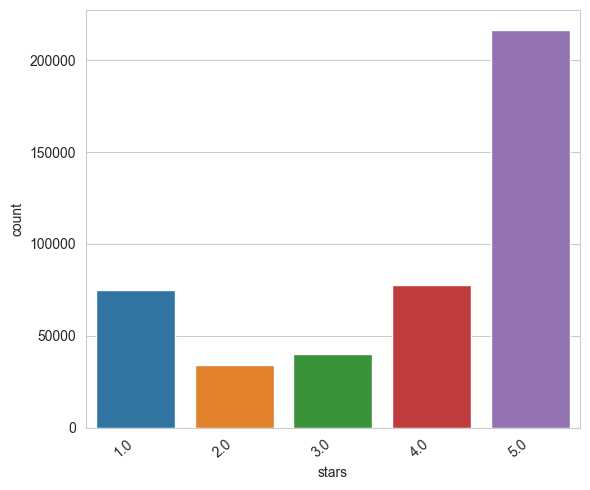

In [8]:
# plot the data distribution
sns.set_style('whitegrid')
plt.figure(figsize=(6, 5))
ax = sns.countplot(x='stars', data=dataset)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

In [9]:
# define feature and target
review = dataset["text"].values
stars = dataset[["stars"]].values

# split the dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(review, stars, test_size = 0.20, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(354530,) (354530, 1)
(88633,) (88633, 1)


In [10]:
#apply tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 138403 unique tokens.


In [11]:
# transform feature to tensors and pad for better comparison
train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_seq = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print('Shape of train tensor:', train_padded.shape)
print('Shape of validation tensor:', test_padded.shape)

Shape of train tensor: (354530, 200)
Shape of validation tensor: (88633, 200)


In [12]:
# encode the target variable
encode = OneHotEncoder()

training_labels = encode.fit_transform(y_train)
test_labels = encode.transform(y_test)


In [13]:
# make sure everything looks good
print(train_padded.shape)
print(test_labels.shape)
print(test_padded.shape)
print(training_labels.shape)
print(type(train_padded))
print(type(test_padded))
print(type(training_labels))
print(type(test_labels))

(354530, 200)
(88633, 5)
(88633, 200)
(354530, 5)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'scipy.sparse._csr.csr_matrix'>
<class 'scipy.sparse._csr.csr_matrix'>


In [14]:
# The labels must be converted to arrays
# Convert the labels to arrays
training_labels = training_labels.toarray()
test_labels = test_labels.toarray()

print(type(training_labels))
print(type(test_labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [17]:
# initiate and define the model
model = Sequential()

model.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))
model.add(Conv1D(48, 5, activation='relu', padding='valid'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

# show the model structure
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [18]:
#compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
# save history in tensorboard
log_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [20]:
# set parameters and train the model
epochs = 8
batch_size = 128

history = model.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    validation_split=0.2,
                    callbacks=[tensorboard_callback])

Epoch 1/8


2022-11-18 16:26:41.618428: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2216/2216 [==============================] - 78s 35ms/step - loss: 0.9694 - accuracy: 0.6308 - val_loss: 0.7621 - val_accuracy: 0.6933
Epoch 2/8
2216/2216 [==============================] - 81s 37ms/step - loss: 0.8504 - accuracy: 0.6671 - val_loss: 0.7445 - val_accuracy: 0.6993
Epoch 3/8
2216/2216 [==============================] - 83s 38ms/step - loss: 0.8180 - accuracy: 0.6768 - val_loss: 0.7415 - val_accuracy: 0.6972
Epoch 4/8
2216/2216 [==============================] - 82s 37ms/step - loss: 0.7945 - accuracy: 0.6851 - val_loss: 0.7454 - val_accuracy: 0.6962
Epoch 5/8
2216/2216 [==============================] - 90s 41ms/step - loss: 0.7761 - accuracy: 0.6905 - val_loss: 0.7447 - val_accuracy: 0.7002
Epoch 6/8
2216/2216 [==============================] - 89s 40ms/step - loss: 0.7609 - accuracy: 0.6964 - val_loss: 0.7534 - val_accuracy: 0.6961
Epoch 7/8
2216/2216 [==============================] - 90s 41ms/step - loss: 0.7454 - accuracy: 0.7029 - val_loss: 0.7594 - val_accuracy: 0.

In [21]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_padded, test_labels, batch_size=128)

Evaluate on test data
693/693 [==============================] - 5s 7ms/step - loss: 0.7662 - accuracy: 0.6965


In [22]:
# predict labels and transform form for confusion matrix
pred_labels = model.predict(test_padded)
pred_labels = tf.math.softmax(pred_labels)
pred_labels = np.argmax(pred_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)


2770/2770 [==============================] - 5s 2ms/step


<AxesSubplot: >

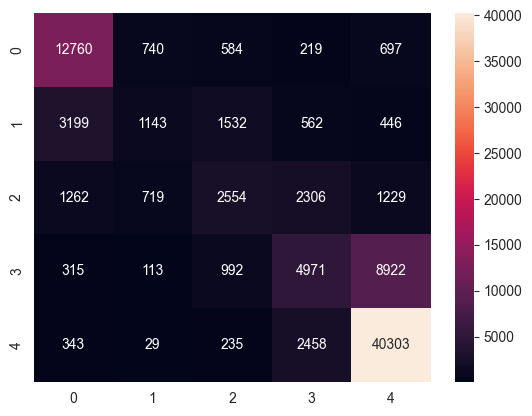

In [23]:
sns.heatmap(tf.math.confusion_matrix(test_labels, pred_labels), annot=True, fmt='g')

In [24]:
# show the classification report
print(classification_report(pred_labels, test_labels))

              precision    recall  f1-score   support

           0       0.85      0.71      0.78     17879
           1       0.17      0.42      0.24      2744
           2       0.32      0.43      0.37      5897
           3       0.32      0.47      0.38     10516
           4       0.93      0.78      0.85     51597

    accuracy                           0.70     88633
   macro avg       0.52      0.56      0.52     88633
weighted avg       0.78      0.70      0.73     88633



In [25]:
#look at tensorboard
%tensorboard --logdir logs/fit